# Archaeological Pattern Detection - Ultra-Strict Filtering

Based on the previous analysis, we now apply the most restrictive filtering to identify potential archaeological features:
- Target 10-50 candidate features (not 348)
- Focus on complete geometric shapes (rectangles, circles)
- Require specific size ranges (100-300m enclosures)
- Look for organized compound structures

## Step 1: Setup and Data Loading

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
from skimage import exposure, filters
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
import rasterio
from scipy.ndimage import gaussian_filter
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported.")

Libraries imported.


In [2]:
# Load DTM data
dtm_path = '/Users/shg/Projects/openai-a-z-challenge/data/raw/TAL_A01_2018/TAL_A01_2018_DTM/TAL01L0002C0003.grd'

with rasterio.open(dtm_path) as src:
    dtm_data = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask invalid values
dtm_data = np.where(dtm_data == src.nodata, np.nan, dtm_data)
dtm_data = np.nan_to_num(dtm_data, nan=np.nanmean(dtm_data))

print(f"DTM file loaded. Shape: {dtm_data.shape}, Resolution: {abs(transform[0]):.2f}m/pixel")

DTM file loaded. Shape: (1001, 1001), Resolution: 1.00m/pixel


## Step 2: Enhanced Preprocessing for Archaeological Features

In [3]:
# Create hillshade
def hillshade(elevation, azimuth=315, angle_altitude=45):
    x, y = np.gradient(elevation)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

# Multi-directional hillshade for better feature detection
hillshade_315 = hillshade(dtm_data, azimuth=315)
hillshade_45 = hillshade(dtm_data, azimuth=45)
hillshade_135 = hillshade(dtm_data, azimuth=135)
hillshade_225 = hillshade(dtm_data, azimuth=225)

# Combine hillshades
combined_hillshade = np.maximum.reduce([hillshade_315, hillshade_45, hillshade_135, hillshade_225])

# Enhanced high-pass filter specifically for archaeological features (50-400m)
# Use multiple sigma values to capture different feature scales
sigma_small = 5   # ~5m features
sigma_medium = 25  # ~25m features
sigma_large = 50   # ~50m features

smoothed_small = gaussian_filter(dtm_data, sigma=sigma_small)
smoothed_medium = gaussian_filter(dtm_data, sigma=sigma_medium)
smoothed_large = gaussian_filter(dtm_data, sigma=sigma_large)

# Multi-scale high-pass filtering
highpass_medium = dtm_data - smoothed_medium
highpass_large = dtm_data - smoothed_large

# Combine for archaeological feature scale
archaeological_filter = (highpass_medium + highpass_large) / 2

# Apply to hillshade
filtered_hillshade = combined_hillshade + 50 * archaeological_filter
filtered_hillshade = np.clip(filtered_hillshade, 0, 255)

print("Multi-directional hillshade and archaeological-scale filtering completed.")

Multi-directional hillshade and archaeological-scale filtering completed.


## Step 3: Ultra-Strict Hough Transform and Line Detection

In [4]:
# More sensitive edge detection for subtle archaeological features
edges = canny(filtered_hillshade, sigma=1.5, low_threshold=15, high_threshold=45)

# Hough transform with higher precision for archaeological features
tested_angles = np.linspace(-np.pi/2, np.pi/2, 180)  # 1-degree precision
h, theta, d = hough_line(edges, theta=tested_angles)

# More selective peak detection
hough_peaks = hough_line_peaks(h, theta, d,
                              min_distance=20,     # Increased separation
                              min_angle=10,        # Increased angle separation
                              threshold=0.4*np.max(h))  # Higher threshold

# Extract line parameters
lines = []
for _, angle, dist in zip(*hough_peaks):
    lines.append((angle, dist))

print(f"Initial lines detected: {len(lines)}")

Initial lines detected: 1


## Step 4: Archaeological-Specific Filtering

In [5]:
def line_endpoints(angle, dist, img_shape):
    """Calculate line endpoints within image bounds"""
    cos_theta, sin_theta = np.cos(angle), np.sin(angle)
    x0, y0 = cos_theta * dist, sin_theta * dist

    # Find intersections with image boundaries
    height, width = img_shape
    intersections = []

    # Check all four boundaries
    boundaries = [(0, width, 0, 0), (0, width, height-1, height-1),
                  (0, 0, 0, height), (width-1, width-1, 0, height)]

    for x1, x2, y1, y2 in boundaries:
        if x1 == x2:  # Vertical boundary
            x = x1
            if abs(cos_theta) > 1e-6:
                y = y0 - (x0 - x) * sin_theta / cos_theta
                if y1 <= y <= y2:
                    intersections.append((x, y))
        else:  # Horizontal boundary
            y = y1
            if abs(sin_theta) > 1e-6:
                x = x0 - (y0 - y) * cos_theta / sin_theta
                if x1 <= x <= x2:
                    intersections.append((x, y))

    if len(intersections) >= 2:
        return intersections[0], intersections[1]
    return None, None

def line_length(p1, p2):
    """Calculate line length in meters"""
    if p1 is None or p2 is None:
        return 0
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def angle_difference(a1, a2):
    """Calculate minimum angle difference between two angles"""
    diff = abs(a1 - a2)
    return min(diff, np.pi - diff)

# Step 4.1: Strict Length Filtering (100-300m for enclosure features)
length_filtered_lines = []
for angle, dist in lines:
    p1, p2 = line_endpoints(angle, dist, filtered_hillshade.shape)
    length = line_length(p1, p2)

    # Stricter length constraints for archaeological enclosures
    if 100 <= length <= 300:  # Focus on enclosure-sized features
        length_filtered_lines.append((angle, dist, p1, p2, length))

print(f"After strict length filter (100-300m): {len(length_filtered_lines)}")

# Step 4.2: Geometric Relationship Filtering
def find_geometric_groups(lines, angle_tolerance=np.pi/36, distance_tolerance=50):
    """Find groups of lines that form geometric patterns"""
    if len(lines) < 2:
        return []

    geometric_groups = []

    for i, (angle1, dist1, p1_1, p1_2, len1) in enumerate(lines):
        group = [(angle1, dist1, p1_1, p1_2, len1)]

        for j, (angle2, dist2, p2_1, p2_2, len2) in enumerate(lines[i+1:], i+1):
            angle_diff = angle_difference(angle1, angle2)

            # Check for parallel or perpendicular relationships
            is_parallel = angle_diff < angle_tolerance
            is_perpendicular = abs(angle_diff - np.pi/2) < angle_tolerance

            if is_parallel or is_perpendicular:
                # Check spatial proximity
                min_dist = min(
                    line_length(p1_1, p2_1), line_length(p1_1, p2_2),
                    line_length(p1_2, p2_1), line_length(p1_2, p2_2)
                )

                if min_dist <= distance_tolerance:
                    group.append((angle2, dist2, p2_1, p2_2, len2))

        # Only keep groups with multiple lines (potential structures)
        if len(group) >= 2:
            geometric_groups.append(group)

    return geometric_groups

geometric_groups = find_geometric_groups(length_filtered_lines)
print(f"Geometric groups found: {len(geometric_groups)}")

# Step 4.3: Shape Completion Analysis
def analyze_shape_completion(group, completion_threshold=0.7):
    """Analyze if a group of lines forms a potentially complete shape"""
    if len(group) < 3:
        return False, 0

    # Calculate convex hull area and perimeter coverage
    all_points = []
    total_line_length = 0

    for _, _, p1, p2, length in group:
        all_points.extend([p1, p2])
        total_line_length += length

    if len(all_points) < 6:  # Need at least 3 lines
        return False, 0

    # Simple convex hull perimeter estimation
    points = np.array(all_points)
    x_range = np.max(points[:, 0]) - np.min(points[:, 0])
    y_range = np.max(points[:, 1]) - np.min(points[:, 1])
    estimated_perimeter = 2 * (x_range + y_range)  # Rectangle approximation

    completion_ratio = total_line_length / estimated_perimeter if estimated_perimeter > 0 else 0

    is_complete = completion_ratio >= completion_threshold

    return is_complete, completion_ratio

# Step 4.4: Final Archaeological Candidate Selection
archaeological_candidates = []
for group in geometric_groups:
    is_complete, completion_ratio = analyze_shape_completion(group)

    if is_complete and len(group) >= 3:  # Require at least 3 lines forming a shape
        archaeological_candidates.append({
            'lines': group,
            'completion_ratio': completion_ratio,
            'line_count': len(group)
        })

print(f"Final archaeological candidates: {len(archaeological_candidates)}")

# Extract final lines for visualization
final_lines = []
for candidate in archaeological_candidates:
    final_lines.extend(candidate['lines'])

print(f"Total lines in final candidates: {len(final_lines)}")

After strict length filter (100-300m): 0
Geometric groups found: 0
Final archaeological candidates: 0
Total lines in final candidates: 0


## Step 5: Archaeological Pattern Visualization

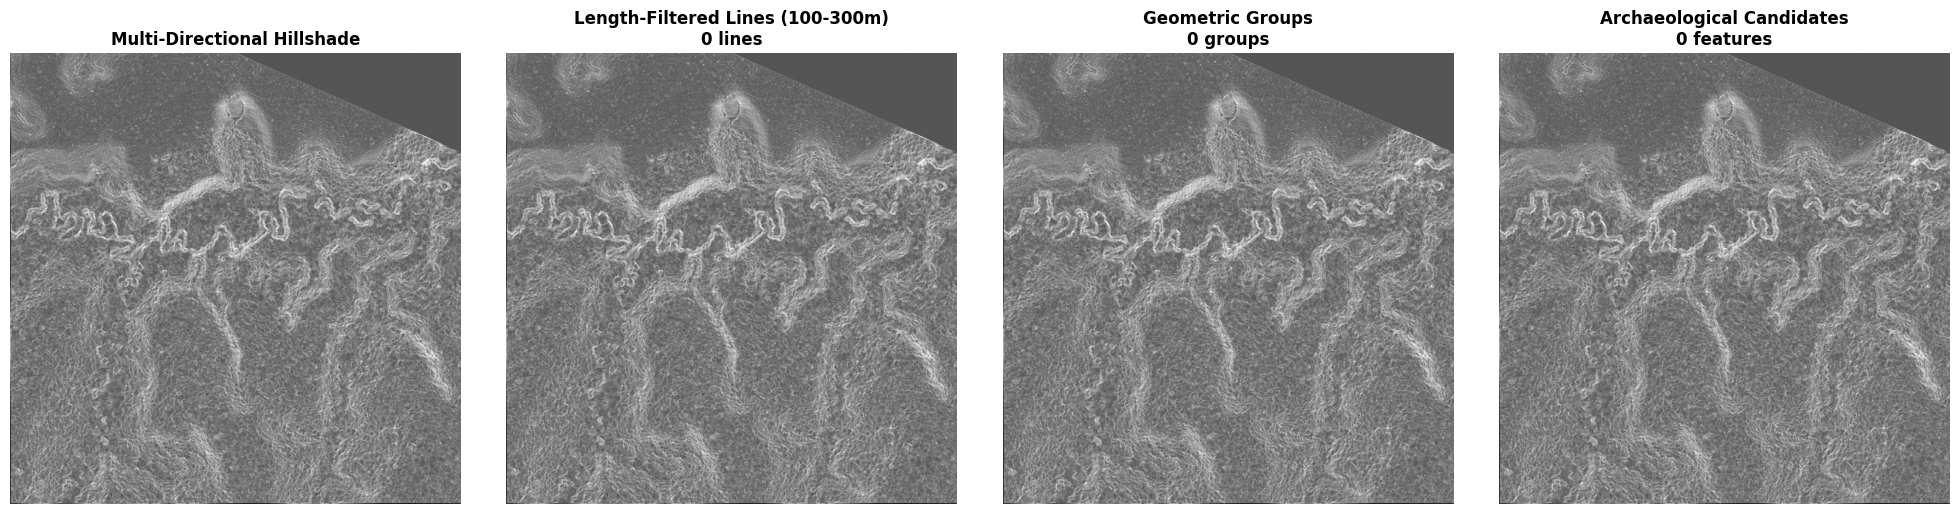

Archaeological pattern analysis saved to archaeological_pattern_results.png

No archaeological candidates detected with current parameters.
Consider adjusting filtering parameters or examining different tile regions.


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Enhanced hillshade
axes[0].imshow(combined_hillshade, cmap='gray', aspect='equal')
axes[0].set_title('Multi-Directional Hillshade', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Length-filtered lines
axes[1].imshow(combined_hillshade, cmap='gray', aspect='equal')
for angle, dist, p1, p2, length in length_filtered_lines:
    if p1 and p2:
        axes[1].plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', linewidth=1.5, alpha=0.7)
axes[1].set_title(f'Length-Filtered Lines (100-300m)\n{len(length_filtered_lines)} lines',
                 fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Geometric groups
axes[2].imshow(combined_hillshade, cmap='gray', aspect='equal')
colors = plt.cm.Set3(np.linspace(0, 1, len(geometric_groups)))
for i, group in enumerate(geometric_groups):
    color = colors[i]
    for angle, dist, p1, p2, length in group:
        if p1 and p2:
            axes[2].plot([p1[0], p2[0]], [p1[1], p2[1]],
                        color=color, linewidth=2, alpha=0.8)
axes[2].set_title(f'Geometric Groups\n{len(geometric_groups)} groups',
                 fontsize=12, fontweight='bold')
axes[2].axis('off')

# 4. Final archaeological candidates
axes[3].imshow(combined_hillshade, cmap='gray', aspect='equal')
candidate_colors = plt.cm.viridis(np.linspace(0, 1, len(archaeological_candidates)))
for i, candidate in enumerate(archaeological_candidates):
    color = candidate_colors[i]
    for angle, dist, p1, p2, length in candidate['lines']:
        if p1 and p2:
            axes[3].plot([p1[0], p2[0]], [p1[1], p2[1]],
                        color=color, linewidth=3, alpha=0.9)

    # Add candidate labels
    if candidate['lines']:
        center_x = np.mean([p[0] for _, _, p1, p2, _ in candidate['lines'] for p in [p1, p2] if p])
        center_y = np.mean([p[1] for _, _, p1, p2, _ in candidate['lines'] for p in [p1, p2] if p])
        axes[3].text(center_x, center_y, f'C{i+1}',
                    fontsize=10, fontweight='bold', color='white',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

axes[3].set_title(f'Archaeological Candidates\n{len(archaeological_candidates)} features',
                 fontsize=12, fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('/Users/shg/Projects/openai-a-z-challenge/archaeological_pattern_results.png',
            dpi=300, bbox_inches='tight')
plt.show()

print(f"Archaeological pattern analysis saved to archaeological_pattern_results.png")

# Summary statistics
if archaeological_candidates:
    print("\n=== ARCHAEOLOGICAL CANDIDATE SUMMARY ===")
    for i, candidate in enumerate(archaeological_candidates):
        print(f"Candidate {i+1}:")
        print(f"  - Lines: {candidate['line_count']}")
        print(f"  - Shape completion: {candidate['completion_ratio']:.2f}")
        print(f"  - Total length: {sum(line[4] for line in candidate['lines']):.1f}m")
else:
    print("\nNo archaeological candidates detected with current parameters.")
    print("Consider adjusting filtering parameters or examining different tile regions.")